## Goals: Training the _Final_ Models

This notebook trains the model on the full _baseline_dataset_ for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic _regions_.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.


In [ ]:
import os
import sys

import joblib
import numpy as np
import pandas as pd

from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.model import (
    split_dataset,
    compare_models_per_station,
    XGBQRFModel,
)

from src.utils.helpers import check_columns_exist

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

##### Constants :

- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **qrf**: Quantile Random Forest (natively produces prediction intervals) - **Baseline model**.
- **ensemble**: An ensemble of `XGBQRF` custom models where each model is trained on a region and a third model is trained on the entire dataset. The final prediction is a weighted average of the models based on the inputs.


In [96]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

# This list should be the same as the one used in the previous notebook as it will be used to fetch the data
DATASET_TRANSFORMS = [
    "rm_gnv_st",  # Remove the geneva station (which is an outlier in the dataset) - Recommended
    "pca",  # Apply PCA to some of the static features (soil composition etc...) - Recommended
    "snow_index",  # Compute the snow index - probability of snow (which is a feature that's estimated from other features in the dataset) - Recommended
    # "snow_index_lag",  # Add lagged features of the snow index - Should be disabled if snow_index is not used
    # "oh_enc_date", # One hot encoding of the date - Not recommended use "cyc_enc_date" instead
    "cyc_enc_date",  # Cyclic encoding of the date - Recommended (https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
    "clust_index",  # Clustering based on the location of the stations
    # "clust_index_oh",  # One hot encoding of the cluster index - Recommended
    "clust_hydro",  # Clustering based on the hydro features
    # "clust_hydro_oh",  # One hot encoding of the hydro cluster index - Recommended
    # "scl_feat", # Scaling to all the features - Not recommended for boosting models (Recommended for NN)
    # "scl_feat_wl",  # Scale all except waterflow lag
    # "rm_wl",  # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma",  # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope",  # add an indicator that is calculated between water_flow_lag 1w and 2w
    # "keep_precipitation_and_evaporation",  # keep precipitation and evaporation features without pca
    # "target_precipitation", # Lagged precipitation feature - experimental should be disabled
]

# Same for these values
# Should be same to previous notebook
PCA_THRESHOLD = 0.98
N_CLUSTER = 10

# For the sake of simplicity, we will use the previously defined fixed dataset name
# DATASET_SPEC = "_".join(DATASET_TRANSFORMS)

# if "pca" in DATASET_TRANSFORMS:
#     DATASET_SPEC += f"_pct_{PCA_THRESHOLD}"

# if "clust_index" in DATASET_TRANSFORMS:
#     DATASET_SPEC += f"_geocl_{N_CLUSTER}"

# if "clust_hydro" in DATASET_TRANSFORMS:
#     DATASET_SPEC += f"_hydcl_{N_CLUSTER}"

DATASET_SPEC = "custom"

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4  # Number of weeks to predict one model is trained per week

FINAL_MODELS = [
    "qrf",
    "xgb_qrf",
]

COLUMNS_TO_DROP = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    "water_flow_week4",
]

ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

### 2. Data Loading

Load in the baseline datasets, create the directory to save models.


In [97]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

### Data Pre-processing

Data pre-processing removal of unnecessary columns, setup of the target


In [ ]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)

Y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    Y_train[i] = dataset_train[f"water_flow_week{i+1}"]

In [98]:
def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
    y_train = {}
    df_copy = df.copy()
    if "water_flow_week1" not in df_copy.columns:
        raise ValueError("water_flow_week1 not in columns")
    for i in range(0, number_of_weeks):
        y_train[i] = df[f"water_flow_week{i+1}"]
        df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
    return df_copy, y_train

In [99]:
train_split, test_split, eval_split = split_dataset(
    dataset_train, 0.75, TIME_VALIDATION
)

x_train, y_train = get_y_train(train_split.drop(columns=["station_code"]))
x_test, y_test = get_y_train(test_split.drop(columns=["station_code"]))
x_eval, y_eval = get_y_train(eval_split)

### 2. Models training


#### a. QRF

- **Training:**  
  Initializes a `RandomForestQuantileRegressor` with the following parameters:

  - 130 estimators
  - Maximum depth of 30
  - Minimum of 20 samples per leaf

  These parameters allow for relatively fast training, though they are not optimized for peak performance.

  The model is then fitted using `X_train` and the corresponding weekly target `y_train[i]`.


In [82]:
X_train_qrf = X_train.drop(columns=["station_code"])

qrf = {}

best_params_qrf = {
    "n_estimators": 130,
    "min_samples_split": 30,
    "min_samples_leaf": 20,
    "max_features": None,
    "max_depth": 30,
    "bootstrap": True,
}

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor
        qrf[i] = RandomForestQuantileRegressor(**best_params_qrf, random_state=SEED)
        qrf[i].fit(X_train_qrf, Y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
Training week 1
Training week 2
Training week 3


#### b. XGBQRF


In [ ]:
xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

xgb_qrf_models = []

for i in range(NUMBER_OF_WEEK):
    print(f"Training XGB-QRF for week {i}")
    xgb_qrf = XGBQRFModel(
        xgb_params={
            "subsample": 0.6,
            "n_estimators": 300,
            "min_child_weight": 5,
            "max_depth": 5,
            "learning_rate": 0.05,
            "gamma": 0.1,
            "colsample_bytree": 0.8,
        },
        qrf_params={
            "n_estimators": 130,
            "min_samples_split": 30,
            "min_samples_leaf": 20,
            "max_features": None,
            "max_depth": 30,
            "bootstrap": True,
        },
        quantiles=xgb_qrf_quantiles,
    )
    xgb_qrf.fit(x_train, y_train[i], eval_set=[(x_test, y_test[i])])
    xgb_qrf_models.append(xgb_qrf)
    time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_path = f"{MODEL_DIR}final/xgb_qrf_{time}_week_{i}.pkl"
    joblib.dump(xgb_qrf, model_path)
    print(f"Model saved to {model_path}")

Training XGB-QRF for week 0
Fitting XGB models
Fitting QRF model
Model saved to ../../../models/rm_gnv_st_pca_snow_index_cyc_enc_date_clust_index_clust_hydro_slct_ma_lag_slope_pct_0.98_geocl_10_hydcl_10/final/xgb_qrf_2025-05-19_19-09-56_week_0.pkl
Training XGB-QRF for week 1
Fitting XGB models
Fitting QRF model
Model saved to ../../../models/rm_gnv_st_pca_snow_index_cyc_enc_date_clust_index_clust_hydro_slct_ma_lag_slope_pct_0.98_geocl_10_hydcl_10/final/xgb_qrf_2025-05-19_19-10-25_week_1.pkl
Training XGB-QRF for week 2
Fitting XGB models
Fitting QRF model
Model saved to ../../../models/rm_gnv_st_pca_snow_index_cyc_enc_date_clust_index_clust_hydro_slct_ma_lag_slope_pct_0.98_geocl_10_hydcl_10/final/xgb_qrf_2025-05-19_19-10-53_week_2.pkl
Training XGB-QRF for week 3
Fitting XGB models
Fitting QRF model
Model saved to ../../../models/rm_gnv_st_pca_snow_index_cyc_enc_date_clust_index_clust_hydro_slct_ma_lag_slope_pct_0.98_geocl_10_hydcl_10/final/xgb_qrf_2025-05-19_19-11-21_week_3.pkl


### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


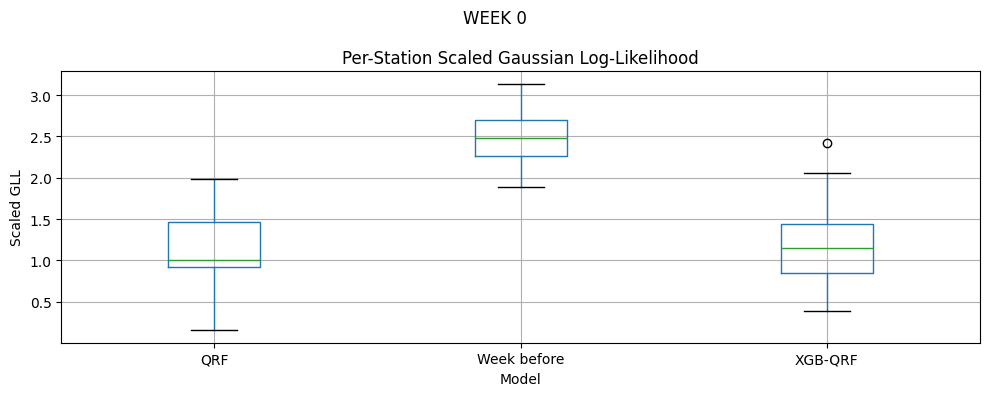

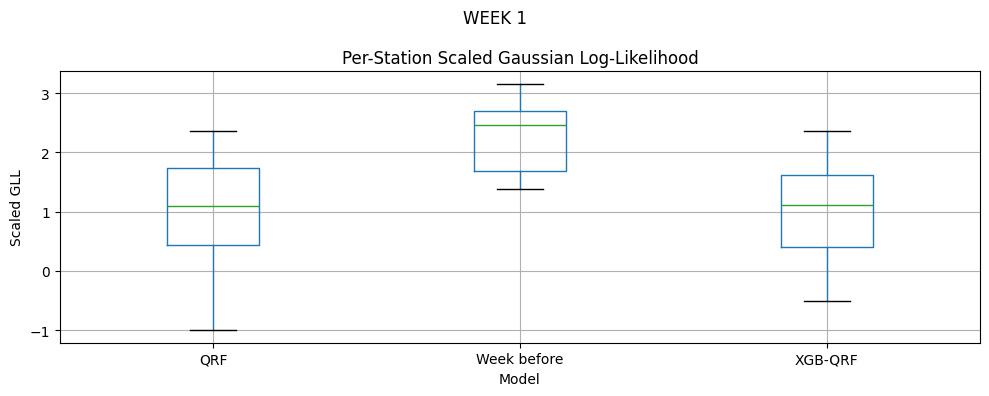

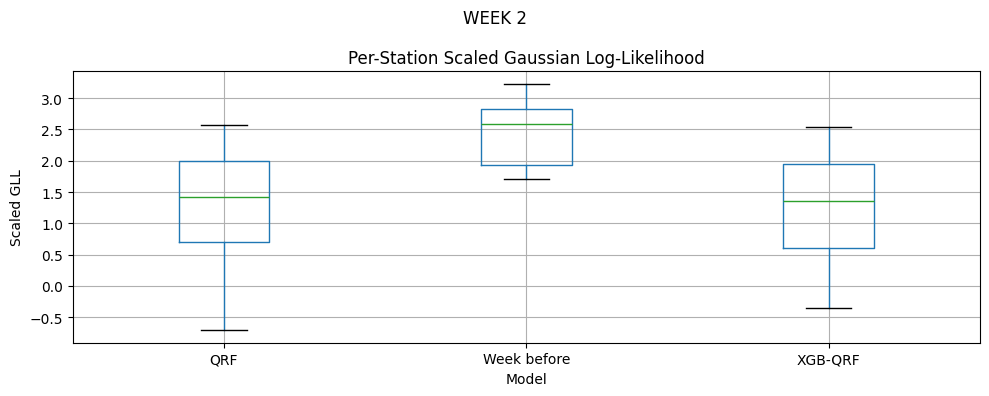

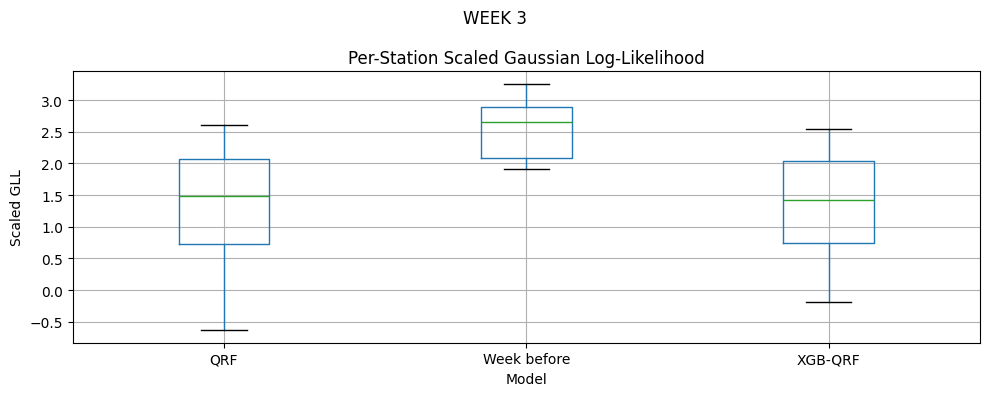

In [87]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append(
        {
            "model": "Week before",
            "prediction": baseline_day_before,
            "dataset": "train",
            "stations": y_train_stations,
            "prediction_interval": None,
        }
    )
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])

        predictions.append(
            {
                "model": "QRF",
                "prediction": y_pred_qrf,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf,
            }
        )
    if "xgb_qrf" in FINAL_MODELS:
        xgb_qrf_pred = xgb_qrf_models[i].predict(X_train_eval.fillna(0))
        xgb_qrf_intervals = np.stack(
            [
                xgb_qrf_pred[:, 0],
                xgb_qrf_pred[:, 2],
            ],
            axis=1,
        )
        xgb_qrf_pred = xgb_qrf_pred[:, 1]

        predictions.append(
            {
                "model": "XGB-QRF",
                "prediction": xgb_qrf_pred,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": xgb_qrf_intervals,
            }
        )

    compare_models_per_station(
        Y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood",
        title=f"WEEK {i}",
    )

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [94]:
for i in range(NUMBER_OF_WEEK):
    print(f"Evaluating week {i}")
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])
        coverage = (Y_train[i].values >= y_pis_qrf[:, 0]) & (
            Y_train[i].values <= y_pis_qrf[:, 1]
        )
        print(
            f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "xgb_qrf" in FINAL_MODELS:
        y_pis_xgb = xgb_qrf_models[i].predict(X_train_eval)
        coverage = (Y_train[i].values >= y_pis_xgb[:, 0]) & (
            Y_train[i].values <= y_pis_xgb[:, 2]
        )
        print(
            f"XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

Evaluating week 0
QRF coverage of the prediction interval for week 0: 0.9762111038914157
XGB-QRF coverage of the prediction interval for week 0: 0.9236878203739802
Evaluating week 1
QRF coverage of the prediction interval for week 1: 0.9765720886578586
XGB-QRF coverage of the prediction interval for week 1: 0.925312251822973
Evaluating week 2
QRF coverage of the prediction interval for week 2: 0.9748393617789329
XGB-QRF coverage of the prediction interval for week 2: 0.9106201718287489
Evaluating week 3
QRF coverage of the prediction interval for week 3: 0.971807089740813
XGB-QRF coverage of the prediction interval for week 3: 0.9036531658364017
